In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as ts
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [37]:
df = pdr.get_data_yahoo("AAPL")

model = keras.models.load_model("../OASiS_Genesis.keras")

model.summary()

[*********************100%%**********************]  1 of 1 completed
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_19 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
data = df.filter(['Close'])
dataset = data.values

scalar = MinMaxScaler(feature_range=(0,1))
scaled_data = scalar.fit_transform(dataset)

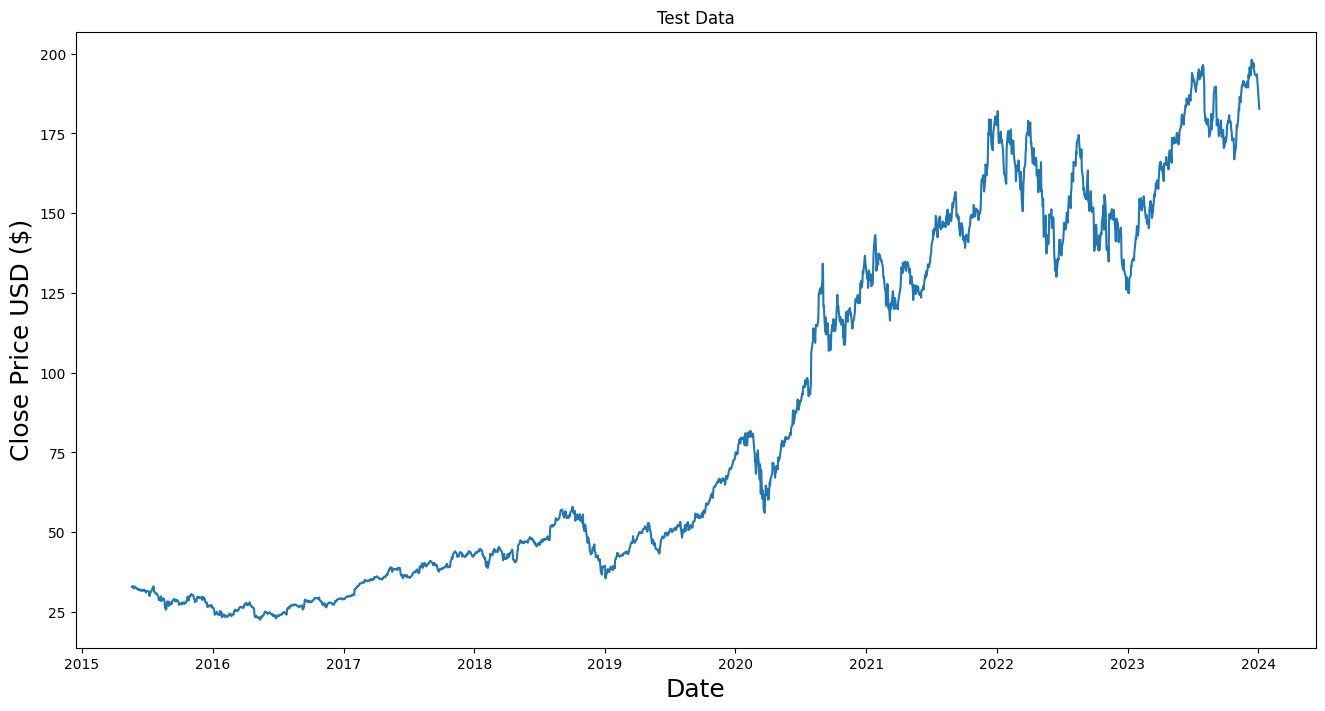

In [39]:
test_data_length = int(np.ceil(len(dataset)*.8))

plt.figure(figsize=(16,8))
plt.title('Test Data')
plt.plot(data.iloc[test_data_length:])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
real_test_data = scaled_data[test_data_length-60:, :]

unknown_test_repetitions = len(scaled_data[test_data_length:,0])
print(unknown_test_repetitions)

x_test = []

x_test.append(real_test_data[0:60, 0])
# At this point I have 1 pages, each with 60 rows, each row has 1 column

x_test = np.array(x_test)
x_test.shape

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

list_predictions = []

for _ in range(unknown_test_repetitions):
    prediction = model.predict(x_test)
    list_predictions.append(prediction)
    
    print(f"Prediction Generated for timestep addition {_} is {prediction}")

    updated_sequence = x_test[:,1:,:]
    prediction = prediction.reshape(1,1,1)
    updated_sequence = np.concatenate((updated_sequence, prediction), axis=1)
    x_test = updated_sequence

In [41]:
list_predictions = np.array(list_predictions)
list_predictions.shape

list_predictions = np.reshape(list_predictions, newshape=(list_predictions.shape[0],1))
list_predictions = scalar.inverse_transform(list_predictions)

print(f"List of predictions for feed forward model is: {list_predictions}")

List of predictions for feed forward model is: [[31.587198  ]
 [31.679115  ]
 [31.726746  ]
 ...
 [-0.73075384]
 [-0.7308073 ]
 [-0.7308601 ]]


In [42]:

FF_data = data.iloc[test_data_length:]
# Add the predictions to the dataframe
FF_data['Predictions'] = list_predictions[:,:]
FF_data

C:\Users\Brandon\AppData\Local\Temp\ipykernel_25436\1311719696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_data['Predictions'] = list_predictions[:,:]


,Close,Predictions
Date,,
2015-05-21,32.847500,31.587198
2015-05-22,33.134998,31.679115
2015-05-26,32.404999,31.726746
2015-05-27,33.009998,31.734009
2015-05-28,32.945000,31.710783
...,...,...
2023-12-28,193.580002,-0.730647
2023-12-29,192.529999,-0.730701
2024-01-02,185.639999,-0.730754


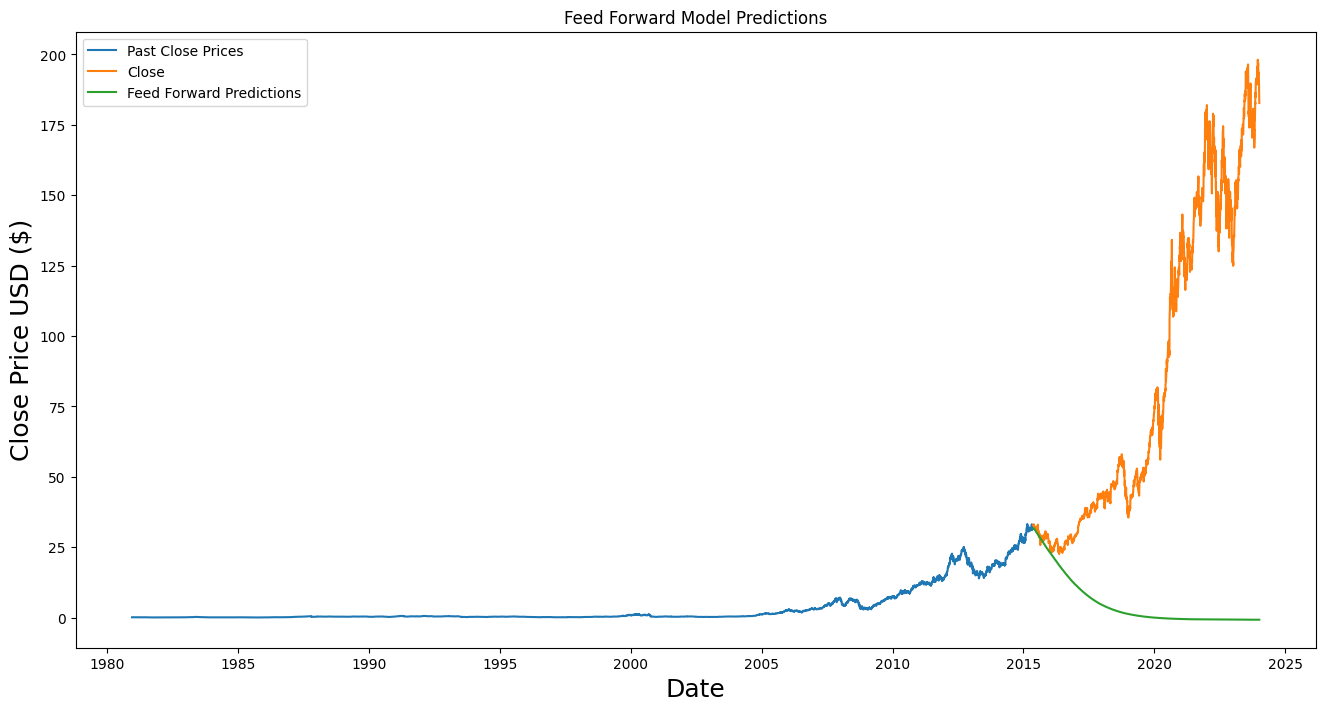

In [43]:

plt.figure(figsize=(16,8))
plt.title('Feed Forward Model Predictions')
plt.plot(data.iloc[:test_data_length])
plt.plot(FF_data[['Close', 'Predictions']])
plt.legend(['Past Close Prices','Close', 'Feed Forward Predictions'], loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
real_test_data = scaled_data[test_data_length-60:, :]

unknown_test_repetitions = len(scaled_data[test_data_length:,0])
print(unknown_test_repetitions)

x_test = []

x_test.append(real_test_data[0:60, 0])
# At this point I have 1 pages, each with 60 rows, each row has 1 column

x_test = np.array(x_test)
x_test.shape

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

list_predictions = []
real_test_data = real_test_data.reshape(real_test_data.shape[0],1,1)
for _ in range(unknown_test_repetitions):
    prediction = model.predict(x_test)
    list_predictions.append(prediction)
    
    print(f"Prediction Generated for timestep addition {_} is {prediction}")

    updated_sequence = x_test[:,1:,:]
    prediction = prediction.reshape(1,1,1)
    updated_sequence = np.concatenate((updated_sequence, real_test_data[60+_,0].reshape(1,1,1)), axis=1)
    x_test = updated_sequence


In [45]:
list_predictions = np.array(list_predictions)
print(len(list_predictions))

list_predictions = np.reshape(list_predictions, newshape=(list_predictions.shape[0],1))
list_predictions = scalar.inverse_transform(list_predictions)

print(f"List of predictions for Corrected feed forward model is: {list_predictions}")
FF_data['Corrected FF Prediction'] = list_predictions[:]

FF_data

2171
List of predictions for Corrected feed forward model is: [[ 31.587198]
 [ 31.72798 ]
 [ 31.886667]
 ...
 [188.60513 ]
 [187.7724  ]
 [186.59874 ]]


C:\Users\Brandon\AppData\Local\Temp\ipykernel_25436\3442205728.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FF_data['Corrected FF Prediction'] = list_predictions[:]


,Close,Predictions,Corrected FF Prediction
Date,,,
2015-05-21,32.847500,31.587198,31.587198
2015-05-22,33.134998,31.679115,31.727980
2015-05-26,32.404999,31.726746,31.886667
2015-05-27,33.009998,31.734009,32.025002
2015-05-28,32.945000,31.710783,32.151115
...,...,...,...
2023-12-28,193.580002,-0.730647,189.593552
2023-12-29,192.529999,-0.730701,189.094666
2024-01-02,185.639999,-0.730754,188.605133


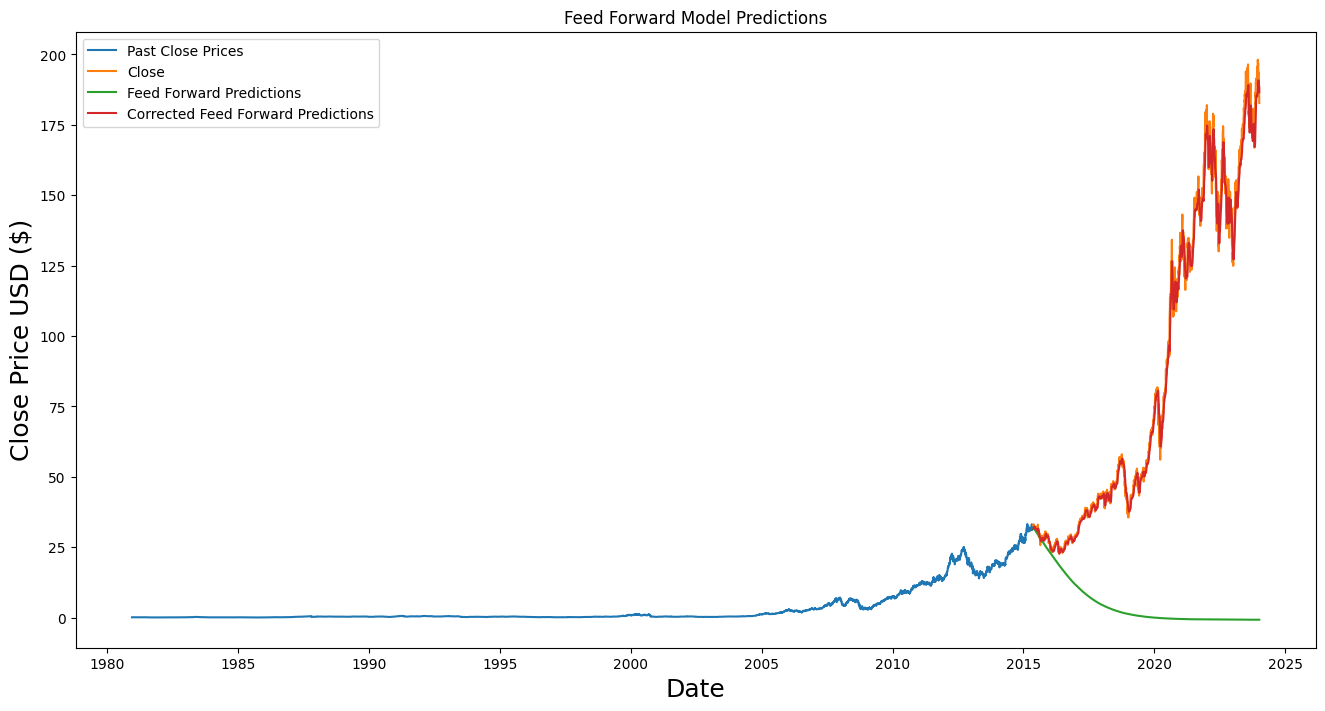

In [46]:
plt.figure(figsize=(16,8))
plt.title('Feed Forward Model Predictions')
plt.plot(data.iloc[:test_data_length])
plt.plot(FF_data[['Close', 'Predictions', 'Corrected FF Prediction']])
plt.legend(['Past Close Prices','Close', 'Feed Forward Predictions', 'Corrected Feed Forward Predictions'], loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()